# Bquery - groupby on-disk

In this notebook we will compare the performance several groupby solutions over out-of-core (disk-based) bcolz files against Python's golden standard: the fast, in-memory Pandas framework.

Our goal is to show how with bcolz you can approach (and in some cases even exceed) the Pandas in-memory performance while working with solutions that only have the intermediate and/or end result in-memory.

We will have two test cases: 
1) a query with a single groupby column and a single aggregated (sum) column
2) a query with five groupby columns and three aggregated (sum) columns

This is a simple example with 1 million rows, but you can experiment with other sizes to see how they affect the outcome.

This performance comparison was run on a 16gb ram, 8 core, SSD-based DigitalOcean server on Ubuntu 14.04. System caching might influence the results, but in our experience this very much resembles our real-life experience. We encourage anyone to have their own test and share them with us.

For the impatient, you can scroll to the end to see a graphical presentation of the performance results.

The bquery framework provides methods to perform query and aggregation operations on bcolz containers, as well as accelerate these operations by pre-processing possible groupby columns.

Bcolz is a light weight package that provides columnar, chunked data containers that can be compressed either in-memory and on-disk. that are compressed by default not only for reducing memory/disk storage, but also to improve I/O speed. It excels at storing and sequentially accessing large, numerical data sets.  

The code you'll find below was inspired on the following nicely written notebooks:  
Blaze - http://nbviewer.ipython.org/url/blaze.pydata.org/notebooks/timings-bcolz.ipynb  
Bcolz - http://nbviewer.ipython.org/github/Blosc/movielens-bench/blob/master/querying-ep14.ipynb

In [1]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import itertools as itt
import time
import shutil
import os
import contextlib
import pandas as pd
import blaze as blz
import bquery
import cytoolz
from cytoolz.curried import pluck as cytoolz_pluck
from collections import OrderedDict
import copy
from prettyprint import pp

In [6]:
elapsed_times = OrderedDict()

@contextlib.contextmanager
def ctime(message=None):
    "Counts the time spent in some context"
    assert message is not None
    global elapsed_times
    t_elapsed = 0.0
    print('\n')
    t = time.time()
    yield
    if message:
        print message + ":  ", 
    t_elapsed = time.time() - t
    print round(t_elapsed, 4), "sec"
    elapsed_times[message] = t_elapsed


ga = itt.cycle(['ES', 'NL'])
gb = itt.cycle(['b1', 'b2', 'b3', 'b4', 'b5'])
gx = itt.cycle([1, 2])
gy = itt.cycle([-1, -2])
rootdir = 'bench-data.bcolz'
if os.path.exists(rootdir):
    shutil.rmtree(rootdir)

n_rows = 1000000

# -- data
z = np.fromiter(((a, b, x, y) for a, b, x, y in itt.izip(ga, gb, gx, gy)),
                dtype='S2,S2,i8,i8', count=n_rows)

In [7]:
ct = bquery.ctable(z, rootdir=rootdir)
ct.flush()

### pandas

In [8]:
print('Simple Test Case')
df = pd.DataFrame(z)
with ctime(message='pandas'):
    result = df.groupby(['f0'], sort=False, as_index=False)['f2'].sum()
# print(result)

Simple Test Case


pandas:   0.0471 sec


### blaze

In [9]:
print('Simple Test Case')
blaze_data = blz.Data(ct.rootdir)
expr = blz.by(blaze_data.f0, sum_f2=blaze_data.f2.sum())
with ctime(message='blaze (pandas + bcolz)'):
    result = blz.compute(expr)
# print result

Simple Test Case


blaze (pandas + bcolz):   0.3018 sec


### bquery without caching

In [10]:
print('Simple Test Case')
with ctime(message='bquery + bcolz'):
    result = ct.groupby(['f0'], ['f2'])
# print(result)

Simple Test Case


bquery + bcolz:   0.1735 sec


### bquery with caching

In [11]:
print('Simple Test Case')
with ctime(message='bquery, create factorization cache'):
    ct.cache_factor(['f0'], refresh=True)

with ctime(message='bquery + bcolz (fact. cached)'):
    result = ct.groupby(['f0'], ['f2'])
# print(result)

Simple Test Case


bquery, create factorization cache:   0.0765 sec


bquery + bcolz (fact. cached):   0.0982 sec


### Running Times Summary

In [12]:
print('Simple Test Case Running Time')
elapsed_times_bak = OrderedDict({ k: v for (k,v) in sorted(elapsed_times.iteritems())})
pp(elapsed_times_bak)

Simple Test Case Running Time
{
    "blaze (pandas + bcolz)": 0.3018171787261963, 
    "bquery + bcolz": 0.17345404624938965, 
    "bquery + bcolz (fact. cached)": 0.09815621376037598, 
    "bquery, create factorization cache": 0.0764780044555664, 
    "pandas": 0.0471041202545166
}


In [13]:
print('Simple Test Case Running Time relative to Pandas')
elapsed_times_bak = OrderedDict({ k: v for (k,v) in sorted(elapsed_times.iteritems())})
pp(elapsed_times_bak)
elapsed_times = elapsed_times_bak
elapsed_times_norm = OrderedDict({ k: v/elapsed_times['pandas'] for (k,v) in sorted(elapsed_times.iteritems())})
print '\nNormalized running time'
pp(elapsed_times_norm)

Simple Test Case Running Time relative to Pandas
{
    "blaze (pandas + bcolz)": 0.3018171787261963, 
    "bquery + bcolz": 0.17345404624938965, 
    "bquery + bcolz (fact. cached)": 0.09815621376037598, 
    "bquery, create factorization cache": 0.0764780044555664, 
    "pandas": 0.0471041202545166
}

Normalized running time
{
    "blaze (pandas + bcolz)": 6.4074475246622695, 
    "bquery + bcolz": 3.68235401302836, 
    "bquery + bcolz (fact. cached)": 2.0838137562066925, 
    "bquery, create factorization cache": 1.6235947947299425, 
    "pandas": 1.0
}


### Graphic Summary

['pandas', 'bquery + bcolz (fact. cached)', 'blaze (pandas + bcolz)', 'bquery + bcolz']


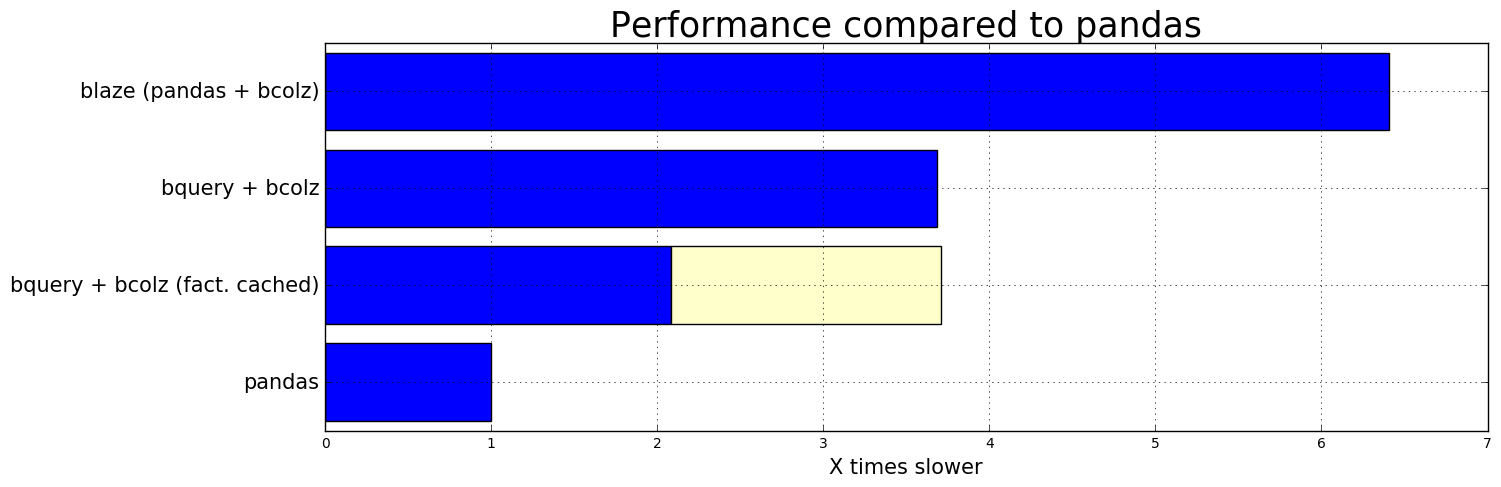

In [14]:
if 'bquery, create factorization cache' in elapsed_times_norm:
    base_bquery = elapsed_times_norm.pop('bquery, create factorization cache')
labels = []
val = []
for k,v in sorted(elapsed_times_norm.iteritems(), reverse=True):
    labels.append(k)
    val.append(v)

pos = np.arange(len(elapsed_times_norm))+.5    # the bar centers on the y axis

print elapsed_times_norm.keys()
plt.figure(1, figsize=[15,5])
plt.grid(True)
plt.barh(pos,val, align='center')
plt.barh(pos,[0, base_bquery, 0,0], 
         left=[0, elapsed_times_norm['bquery + bcolz (fact. cached)'], 0, 0],
         align='center', color = '#FFFFCC')
plt.yticks(pos, labels, fontsize=15)
plt.xlabel('X times slower', fontsize=15)
plt.title('Performance compared to pandas', fontsize=25)

The Light yellow shows the one-time factorization caching (which after the first run can be left out of future queries).  
NB: when data changes, this caching has to be refreshed but it is very useful in most reporting & analytics cases.

## Complex scenario

In [15]:
elapsed_times = OrderedDict()

ga = itt.cycle(['ES', 'NL'])
gb = itt.cycle(['b1', 'b2', 'b3', 'b4'])
gc = itt.cycle([1, 2])
gd = itt.cycle([3, 4, 4, 3])
ge = itt.cycle(['c','d','e'])
gx = itt.cycle([1, 2])
gy = itt.cycle([-1, -2])
gz = itt.cycle([1.11, 2.22, 3.33, 4.44, 5.55])

rootdir = 'bench-data.bcolz'
if os.path.exists(rootdir):
    shutil.rmtree(rootdir)

n_rows = 1000000
print('Rows: ', n_rows)
    
z = np.fromiter(((a, b, c, d, e, x, y, z) for a, b, c, d, e, x, y, z
                 in itt.izip(ga, gb, gc, gd, ge, gx, gy, gz)),
                dtype='S2,S2,i4,i8,S1,i4,i8,f8', count=n_rows)
ct = bquery.ctable(z, rootdir=rootdir, )

# -- pandas --
df = pd.DataFrame(z)
with ctime(message='pandas'):
    result = df.groupby(['f0','f1','f2','f3','f4'], sort=False, as_index=False)['f5','f6','f7'].sum()
# print(result)

# -- bquery --
with ctime(message='bquery + bcolz'):
    result = ct.groupby(['f0','f1','f2','f3','f4'], ['f5','f6','f7'])
# print(result)

with ctime(message='bquery, create factorization cache'):
    ct.cache_factor(['f0','f1','f2','f3','f4'], refresh=True)
    
with ctime(message='bquery over bcolz (factorization cached)'):
    result = ct.groupby(['f0','f1','f2','f3','f4'], ['f5','f6','f7'])
# print(result)

('Rows: ', 1000000)


pandas:   0.1285 sec


bquery + bcolz:   0.654 sec


bquery, create factorization cache:   0.1642 sec


bquery over bcolz (factorization cached):   0.494 sec


In [16]:
print('Complex Test Case Running Time relative to Pandas')
elapsed_times_bak = OrderedDict({ k: v for (k,v) in sorted(elapsed_times.iteritems())})
pp(elapsed_times_bak)
elapsed_times = elapsed_times_bak
elapsed_times_norm = OrderedDict({ k: v/elapsed_times['pandas'] for (k,v) in sorted(elapsed_times.iteritems())})
print '\nNormalized running time'
pp(elapsed_times_norm)

Complex Test Case Running Time relative to Pandas
{
    "bquery + bcolz": 0.6539809703826904, 
    "bquery over bcolz (factorization cached)": 0.49399495124816895, 
    "bquery, create factorization cache": 0.16423702239990234, 
    "pandas": 0.12845802307128906
}

Normalized running time
{
    "bquery + bcolz": 5.091009146386732, 
    "bquery over bcolz (factorization cached)": 3.8455749157374273, 
    "bquery, create factorization cache": 1.2785267784228422, 
    "pandas": 1.0
}


['pandas', 'bquery over bcolz (factorization cached)', 'bquery + bcolz']


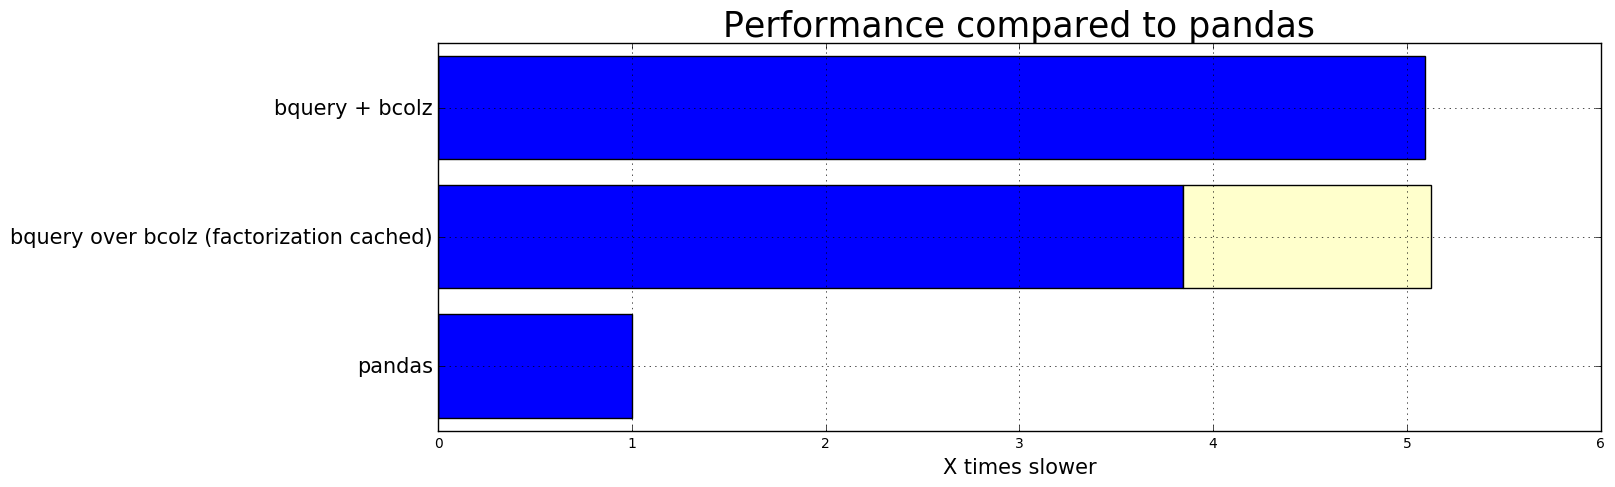

In [17]:
if 'bquery, create factorization cache' in elapsed_times_norm:
    base_bquery = elapsed_times_norm.pop('bquery, create factorization cache')
labels = []
val = []
for k,v in sorted(elapsed_times_norm.iteritems(), reverse=True):
    labels.append(k)
    val.append(v)

pos = np.arange(len(elapsed_times_norm))+.5    # the bar centers on the y axis

print elapsed_times_norm.keys()
plt.figure(1, figsize=[15,5])
plt.grid(True)
plt.barh(pos,val, align='center')
plt.barh(pos,[0, base_bquery, 0], 
         left=[0, elapsed_times_norm['bquery over bcolz (factorization cached)'], 0],
         align='center', color = '#FFFFCC')
plt.yticks(pos, labels, fontsize=15)
plt.xlabel('X times slower', fontsize=15)
plt.title('Performance compared to pandas', fontsize=25)

## Conclusion
Currently -in our experience- the real-life performance of sum aggregations using on-disk bcolz queries depending on machine are normally between 2.0 and 3.0 times slower than similar in-memory Pandas aggregations.

There are many scenarios where you would like to perform a number of groupby operations over a number of large files, creating issues with memory management and hot set selection. However, through bcolz and bquery you can have an out-of-core solution that is near in-memory in terms of size while creating the possibility to handle very large data sets with limited hardware.

It is important to notice that while the end result is a bcolz ctable (which can be out-of-core) and the input can be any out-of-core ctable, the intermediate result will be an in-memory numpy array. This is because most groupby operations on non-sorted tables require random memory access while bcolz is limited to sequential access for optimum performance. However, this memory footprint is limited to the groupby result length and can be further optimized in the future to a per-column usage.  
